In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

# Preparing for Data
print('==> Preparing data..')

# Training Data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Testing Data preparation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:05<00:00, 29268263.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


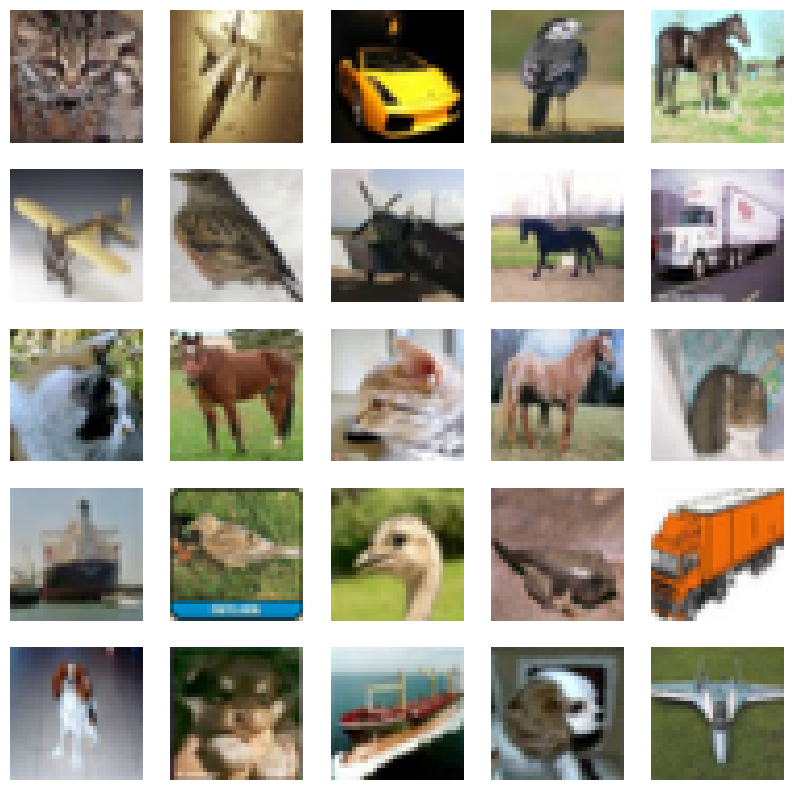

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle

f = open('./data/cifar-10-batches-py/data_batch_1', 'rb')
datadict = cPickle.load(f,encoding='latin1')
f.close()
X = datadict["data"]
Y = datadict['labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np

# Preparing for Data
print('==> Preparing data..')

# Training Data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Testing Data preparation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class YourNet(nn.Module):
    def __init__(self):
        super(YourNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        out = F.softmax(x, dim=1)
        return out

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    count = 0
    loss_fn = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            _, pred = torch.max(output, 1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total, 100. * correct / total))

def main():
    time0 = time.time()
    batch_size = 128
    epochs = 50
    lr = 0.01
    no_cuda = False
    save_model = False
    use_cuda = not no_cuda and torch.cuda.is_available()
    torch.manual_seed(100)
    device = torch.device("cuda" if use_cuda else "cpu")

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

    model = YourNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
           torch.save(model.state_dict(), "cifar_yournet.pt")

    calculate_final_test_accuracy(model, device, test_loader)

    time1 = time.time()
    print('Training and Testing total execution time is: %s seconds ' % (time1 - time0))

def calculate_final_test_accuracy(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    print('\nOverall Test Accuracy: {:.2f}% ({}/{})'.format(
        100. * correct / total, correct, total))

if __name__ == '__main__':
    main()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303640
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.292241
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.244233
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.241020
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.259441
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.203844
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.278822
Train Epoch: 1 [8960/50000 (18%)]	Loss: 2.253110
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.140923
Train Epoch: 1 [11520/50000 (23%)]	Loss: 2.138197
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.163302
Train Epoch: 1 [14080/50000 (28%)]	Loss: 2.135485
Train Epoch: 1 [15360/50000 (31%)]	Loss: 2.178985
Train Epoch: 1 [16640/50000 (33%)]	Loss: 2.108803
Train Epoch: 1 [17920/50000 (36%)]	Loss: 2.137612
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.098821
Train Epoch: 1 [20480/50000 (41%)]	Loss: 2.121325
Train Epoch: 1 [21760/50000 (43%)]	Loss: 2.155154
Train Epoch: 1 [23